In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **General Analysis**

In [2]:
data_path = r"C:\Users\jhoni\Documents\LooperAI\repositorios\bb-tech-challenge\data\raw\storedata_total.xlsx"
df_raw = pd.read_excel(data_path,sheet_name='data',header=0, engine='openpyxl')
df_raw.head(5)

c:\Users\jhoni\Documents\LooperAI\repositorios\bb-tech-challenge\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,2012-09-28,2013-08-11 00:00:00,2013-08-11 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL
1,APCENR,1,2010-12-19,2011-04-01 00:00:00,2014-01-19 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL
2,7UP6MS,0,2010-10-03,2010-12-01 00:00:00,2011-07-06 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,DEL
3,7ZEW8G,0,2010-10-22,2011-03-28 00:00:00,2011-03-28 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM
4,8V726M,1,2010-11-27,2010-11-29 00:00:00,2013-01-28 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM


In [3]:
df_raw.shape

(30801, 15)

In [ ]:
df_raw_raw_raw_raw_raw_raw_raw_raw_raw_raw_raw_raw_raw_raw_raw.dtypes

custid                object
retained               int64
created       datetime64[ns]
firstorder            object
lastorder             object
esent                  int64
eopenrate            float64
eclickrate           float64
avgorder             float64
ordfreq              float64
paperless              int64
refill                 int64
doorstep               int64
favday                object
city                  object
dtype: object

In [ ]:
# Check missing values
missing = df_raw.isnull().sum()
missing_pct = (missing/len(df_raw)*100).round(2)
missing_df = pd.DataFrame(
    {
        "count": missing,
        "pct": missing_pct
    }
)
missing_df.sort_values('pct', ascending=False)

,count,pct
custid,20,0.06
created,20,0.06
firstorder,20,0.06
lastorder,20,0.06
retained,0,0.00
esent,0,0.00
eopenrate,0,0.00
eclickrate,0,0.00
avgorder,0,0.00
ordfreq,0,0.00


In [29]:
# Check correlated nulls in top 4
df_null = df_raw[["custid", "created", "firstorder", "lastorder"]].isnull()

# Identify if all elements al nulls
all_null = df_null.all(axis=1).sum()

# Identify in at least one is null
any_null = df_null.any(axis=1).sum()

print(f"{all_null}, {any_null}")

20, 20


In [32]:
# Check duplicates
duplicates_count = df_raw.duplicated().sum()

# Check duplicates in id
id_duplicates = df_raw['custid'].dropna().duplicated().sum()

print(f"Total duplicates: {duplicates_count}, ID duplicates: {id_duplicates}")

Total duplicates: 0, ID duplicates: 12


# 

# **Target Analysis**

-0.25
0.75


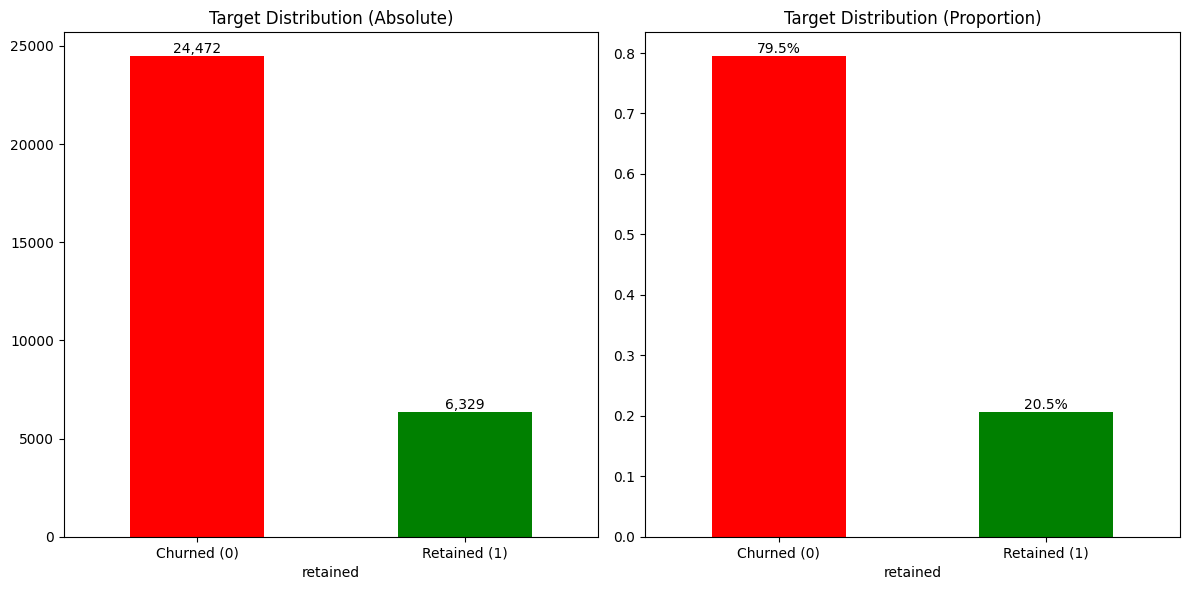

In [ ]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Graph absolute values
df_raw['retained'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=['red','green']
)
axes[0].set_title("Target Distribution (Absolute)")
axes[0].set_xticklabels(["Churned (0)", "Retained (1)"], rotation=0)

# Add bar labels
for p in axes[0].patches:
    axes[0].annotate(
        f'{int(p.get_height()):,}', 
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='bottom'
    )
    
    
# Proportions
df_raw['retained'].value_counts(normalize=True).plot(
    kind='bar',
    ax=axes[1],
    color=["red", "green"]
)
axes[1].set_title("Target Distribution (Proportion)")
axes[1].set_xticklabels(["Churned (0)", "Retained (1)"], rotation=0)

for p in axes[1].patches:
    axes[1].annotate(
        f'{p.get_height():.1%}', 
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='bottom'
    )
    

plt.tight_layout()
plt.show()

In [ ]:
df_raw['retained'].value_counts()print(f"Imbalance ratio: {df_raw['retained'].value_counts()[1] / df_raw['retained'].value_counts()[0]:.1f}:1")

retained
1    24472
0     6329
Name: count, dtype: int64

In [ ]:
print(f"Imbalance ratio: {df_raw['retained'].value_counts()[1] / df_raw['retained'].value_counts()[0]:.1f}:1")

Imbalance ratio: 3.9:1


## Conclusions
The dataset exhibits moderate class imbalance at approximately 79.5% retained vs 20.5% churned (roughly 4:1 ratio). The strategy i'll choose:

1. Metric selection: ROC-AUC will be misleadingly optimistic because the large number of true negatives inflates the FPR denominator. PR-AUC is my primary metric.
2. Training strategy: I'll use class_weight='balanced' for Logistic Regression and scale_pos_weight ≈ 3.87 for XGBoost to prevent the models from optimizing for the majority class.
3. Threshold selection: The default 0.5 threshold will produce high precision but low recall on the churn class. I'll optimize the threshold on the validation set.
4. This is NOT extreme imbalance. At 20.5%, standard techniques like class weights and threshold tuning are sufficient. SMOTE or other resampling methods is not required here.

# **Feature Analysis**

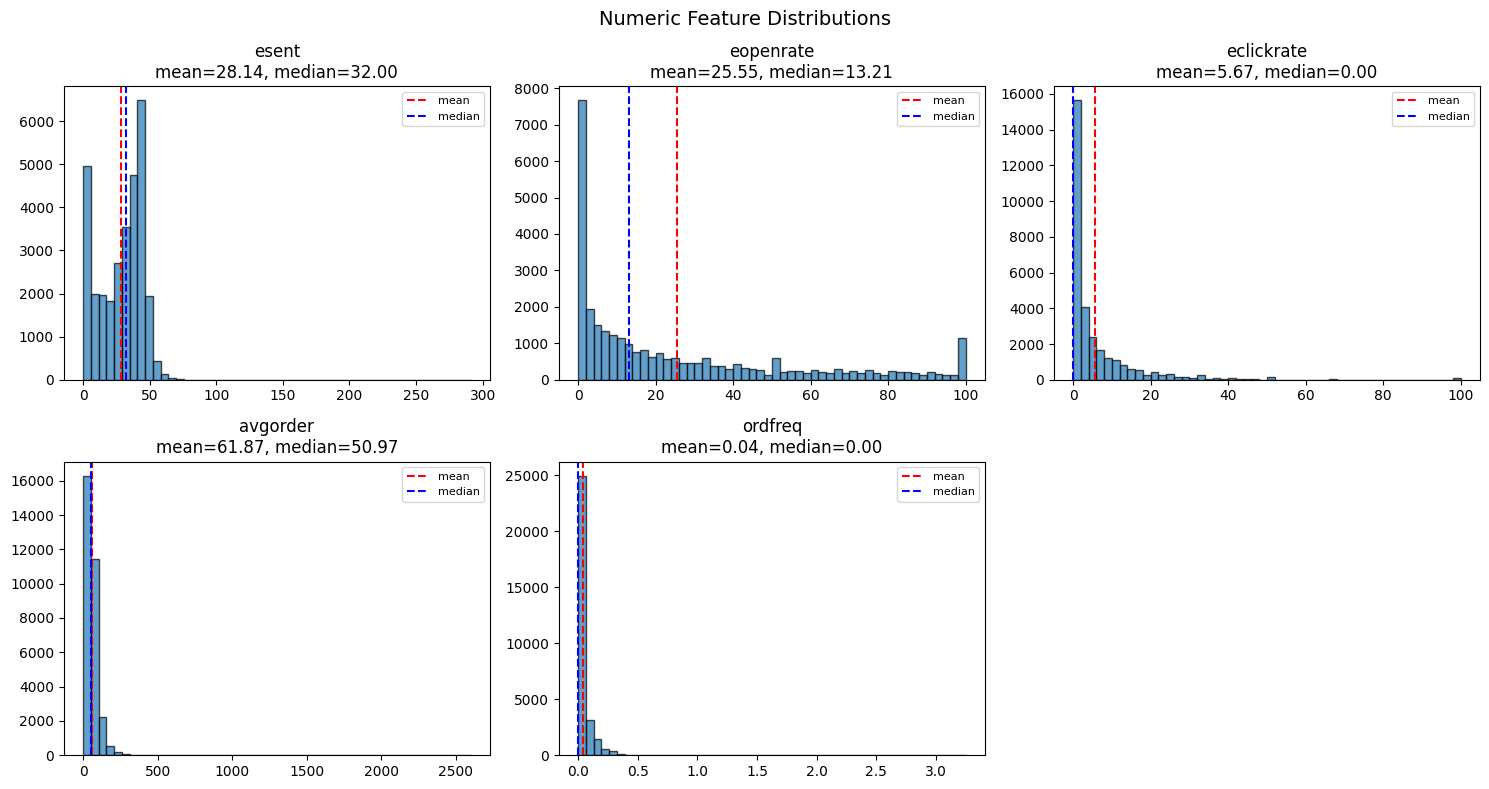

In [73]:
numeric_cols = ["esent", "eopenrate", "eclickrate", "avgorder", "ordfreq"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df_raw[col].dropna(), bins=50, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"{col}\nmean={df_raw[col].mean():.2f}, median={df_raw[col].median():.2f}")
    axes[i].axvline(df_raw[col].mean(), color="red", linestyle="--", label="mean")
    axes[i].axvline(df_raw[col].median(), color="blue", linestyle="--", label="median")
    axes[i].legend(fontsize=8)

axes[-1].axis("off")
plt.suptitle("Numeric Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()


## Comments
The gap between mean and median reveals skewness. For esent and avgorder, if the mean is much higher than median, you have right-skew from outliers. This matters because Logistic Regression assumes a roughly linear relationship with the log-odds — extreme skew creates leverage points. Trees are robust to this, which is one reason XGBoost typically outperforms linear models on raw tabular data.